# 1. Dataset and question
---
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

    This dataset contains information about 21 features of 146 people of Enron which went bankrupt for huge fraud scandal. There were some people of interests(POI) who actively participated in this fraud scandal and gained unjusted profit. This report aims to find certain criteria that can distinguish POI effectively. With this criteria, we can find some suspicious people who were classified as non-POI or identify new person whether he is POI or not. 

## 1) Load datasets
---

In [1]:
#!/usr/bin/python

import sys 
import pickle
import numpy as np
import pandas as pd
import  scipy.stats as stats
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

###
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'def_income_r', 'es_r', 'from_r', 'to_r']  # You will need to use more features  # You will need to use more features
### The first feature must be "poi".

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
my_dataset = data_dict


## 2) Remove outliers
---
    I found one sample extremely larger than the others, which was total. I decided to delete from my data

In [2]:
### Task 2: Remove outliers
del my_dataset['TOTAL']

# 2. Features
---
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]
    There were three categories for features.
    
    1) financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

    2) email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

    3) POI label: [‘poi’] (boolean, represented as integer)
    
    

## 1) Select features
---
    The overall strategy for selecting features was that include as many features as possible except for the too irrelevent features that would only cause noise. At first, I excluded the email_address which definatly would not help. Next, I picked some variables based on my hypothesis
    
    1) POI could take advantage of company(Amount matter):'salary', 'bonus', 'long_term_incentive', 'deferral_payments', 'loan_advances', 'other', 'total_stock_value'
    
    2) POI could contact with the other POI closely: 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'

## 2) Create new features
---
    I thought of several more hypothesis to add new features.
    
    1) POI could have lower deferred ratio because they had inside information(Ratio matter): 
    def_income_r = ('deferred_income'/'salary'+'bonus'+'long_term_incentive')
    es_r = ('exercised_stock_options'/'total_stock_value')
    
    2) Interaction could be captured better in ratio than amount of email.
    from_r = ('from_poi_to_this_person'/'from_messages')
    to_r = ('from_this_person_to_poi'/'to_messages')
    
    As a result, the 13 features I chose are following.
    - 'poi','salary', 'bonus', 'long_term_incentive', 'deferral_payments', 'loan_advances', 'other', 'total_stock_value', 'shared_receipt_with_poi', 'def_income_r', 'es_r', 'from_r', 'to_r'
    

In [3]:
# Task 3: Create new feature(s)
for i in my_dataset:
    try:
        my_dataset[i]['def_income_r'] = my_dataset[i]['deferred_income'] / -float((my_dataset[i]['salary'] + my_dataset[i]['bonus'] + my_dataset[i]['long_term_incentive']))
    except:
        my_dataset[i]['def_income_r'] = 'NaN'
    try:
        my_dataset[i]['es_r'] = abs(my_dataset[i]['exercised_stock_options'] / float(my_dataset[i]['total_stock_value']))
    except:
        my_dataset[i]['es_r'] = 'NaN'
    try:
        my_dataset[i]['from_r'] = my_dataset[i]['from_poi_to_this_person'] / float(my_dataset[i]['from_messages'])
    except:
        my_dataset[i]['from_r'] = 'NaN'
    try:
        my_dataset[i]['to_r'] = my_dataset[i]['from_this_person_to_poi'] / float(my_dataset[i]['to_messages'])
    except:
        my_dataset[i]['to_r'] = 'NaN'

## 4) Feature Labels Split
---
    I splited the label(POI) from the rest of features

In [4]:
### Extract features and labels from dataset for local testing
features_list = ['poi','salary', 'bonus', 'long_term_incentive', 'deferral_payments', 'loan_advances', 'other', 'total_stock_value',\
                'shared_receipt_with_poi', 'def_income_r', 'es_r', 'from_r', 'to_r']
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

## 3) Process 'Nan'
---
    This part was tricky, but very important since I put a lot of features in the model and there are lots of 'NaN' in dataset. I decided to put mean value because I'll later scale all of the features with mean.

In [5]:
import numpy.ma as ma
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0).fit(features)
features_im = imr.transform(features)

## 5) Feature scaling
---
    Since all the features have different scale, I standardize with each of mean and variance.

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_sc = scaler.fit_transform(features_im)

## 5) PCA
---
    I thought 12 features are still too much for 146 observations. I tried to capture the at least 90% of variance of features. As a result, 8 principle components were chosen.


0.342054552748
0.468594267683
0.585045071051
0.67941776334
0.753380762723
0.818048080509
0.871223661843
0.915566013996
0.947583702188
0.970328918321
0.990868838914


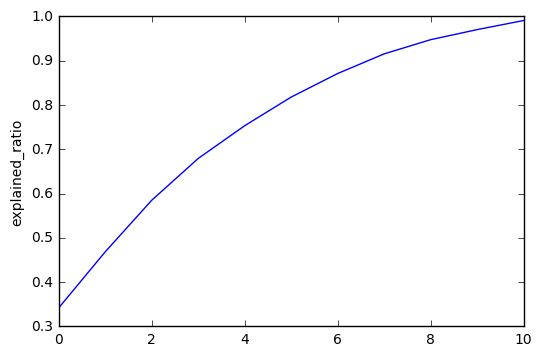

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
explained =[]

for i in range(1,len(features_sc[0]+1)):
    pca = PCA(n_components = i)
    pca.fit(features_sc)
    explained_ratio = pca.explained_variance_ratio_
    explained.append(sum(explained_ratio))
    print sum(explained_ratio)

plt.plot(explained)
plt.ylabel('explained_ratio')
plt.show()

# 3. Algorithms
---
WhatWhat algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”] algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

## 1) Metric for algorithms
---
    There are two labels for each observation. However, the amount of both labels differed greatly. So I decided to use precision and accuracy to evaluate the models. Precision was especially important because there are already too few POI so that just assuming all the people non-POI would result high accuracy. First, I need to see the portion of POI among the whole. 13.4 percent of the people were POI so that precision should be better than that result. 

In [8]:
standard = sum(labels)/len(labels)
print standard

0.134328358209


## 2) Algorithms candidates
---
    I've selected 5 candidates for algorithms which I learn from the lessons: Gaussian Naive Bayes, Support Vector Classifier, K-Nearest Centroid, Random Forest Classifier and Adaboost Classifier. I decided to select 2 of them and develop further. I modified test_classifier function since I already divided features and labels.

In [9]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import KFold
from tester import *

gau = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', GaussianNB())])
sv = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', SVC())])
nv = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', NearestCentroid())])
rfc = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', RandomForestClassifier())])
abc = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', AdaBoostClassifier())])

test_classifier(gau, my_dataset, features_list)
test_classifier(sv, my_dataset, features_list)
test_classifier(nv, my_dataset, features_list)
test_classifier(rfc, my_dataset, features_list)
test_classifier(abc, my_dataset, features_list)

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=8, whiten=False)), ('clf', GaussianNB())])
	Accuracy: 0.82600	Precision: 0.36867	Recall: 0.30600	F1: 0.33443	F2: 0.31677
	Total predictions: 14000	True positives:  612	False positives: 1048	False negatives: 1388	True negatives: 10952

Got a divide by zero when trying out: Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=8, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Precision or recall may be undefined due to a lac

## 3) Select Algorithm
---
    Performances of classifiers were highly disappointing, but I have to admit that there are too few observations. Based on the performance observed, I chose Gaussian Naive Bayse and K-nearest centroids algorithms. Now, I'll try to tune parameters to see if the performance gets better. 
    

## 4) Hyperparameters Tuning
---
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]

    In fact, choosing which alogorithm to use before tuning hyperparameters of algorithms is impoerfect because the performance of classifiers differ greatly depending on the hyperparameters. Although this fact make my logic vulnerable, I had to focus on few classifiers to tune hyperparameters because there are too many hyperparameters to tune. Tuning the hyperparameters can make best classifer for a given dataset. 

### (1) Gaussian Naive Bayes
---
    Gaussian Naive Bayes had only one parameter: Prior. Prior means prior probabilities of the classes. However, since features were reduced through PCA, it is hard to set prior. As a result, there can be only one candidate for Gaussian NB.
    
    * GaussianNB()
	Accuracy: 0.82600	Precision: 0.36867	Recall: 0.30600	F1: 0.33443	F2: 0.31677
	Total predictions: 14000	True positives:  612	False positives: 1048	False negatives: 1388	True negatives: 10952

### (2) K-Nearest Centroids
---
    K-Nearest Centroids algorithm is one of the unsupervised classifications, Clustering. There are two parameters for Neareset Centroid: metric and shrink_threshold. I can either change Manhattan or Euclidean metrics to calculate the distance. Shrink_threshold represent threshold for shrinking centroids to remove features. I looped through the possible parameters to see which one is the best.

In [10]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

print "Euclidean:"
for i in range(30):
    nv = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', NearestCentroid(shrink_threshold = i/float(10)))])
    test_classifier(nv, my_dataset, features_list)
print "Manhattan"
for i in range(17):
    nv = Pipeline([('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), ('scale', StandardScaler()), ('pca', PCA(n_components = 8)), ('clf', NearestCentroid(metric = "manhattan", shrink_threshold = i/float(10)))])
    test_classifier(nv, my_dataset, features_list)


Euclidean:
Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=8, whiten=False)), ('clf', NearestCentroid(metric='euclidean', shrink_threshold=0.0))])
	Accuracy: 0.77464	Precision: 0.29174	Recall: 0.40450	F1: 0.33899	F2: 0.37548
	Total predictions: 14000	True positives:  809	False positives: 1964	False negatives: 1191	True negatives: 10036

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=8, whiten=False)), ('clf', NearestCentroid(metric='euclidean', shrink_threshold=0.1))])
	Accuracy: 0.77321	Precision: 0.29393	Recall: 0.41900	F1: 0.34550	F2: 0.38614
	Total predictions: 14000	True positives:  838	False positives: 2013	False negatives: 1162	True negatives: 9987

Pipeli

    * NearestCentroid(metric='euclidean', shrink_threshold=0.6))])
	Accuracy: 0.76993	Precision: 0.30224	Recall: 0.46650	F1: 0.36682	F2: 0.42076
	Total predictions: 14000	True positives:  933	False positives: 2154	False negatives: 1067	True negatives: 9846


    The best classifier of Nearest Centroids was the one with Euclidean metric and shrinks_threshold of 0.6. It had accuracy of 0.77, precision of 0.30, recall of 0.46 and f1 score of 0.36.


## 5) Check the effects of  new features
---
    To validate the affect of new features I made, I compared with features list without new features('def_income_r', 'es_r', 'from_r', 'to_r')

In [11]:
features_list2 = ['poi','salary', 'bonus', 'long_term_incentive', 'deferral_payments', 'loan_advances', 'other', 'total_stock_value',\
                'shared_receipt_with_poi']

test_classifier(gau, my_dataset, features_list2)
test_classifier(nv, my_dataset, features_list2)


Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=8, whiten=False)), ('clf', GaussianNB())])
	Accuracy: 0.82821	Precision: 0.35928	Recall: 0.25850	F1: 0.30067	F2: 0.27386
	Total predictions: 14000	True positives:  517	False positives:  922	False negatives: 1483	True negatives: 11078

Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=8, whiten=False)), ('clf', NearestCentroid(metric='manhattan', shrink_threshold=1.6))])
	Accuracy: 0.83243	Precision: 0.22627	Recall: 0.07150	F1: 0.10866	F2: 0.08283
	Total predictions: 14000	True positives:  143	False positives:  489	False negatives: 1857	True negatives: 11511



    * Gaussian
    with:    Accuracy: 0.82600    Precision: 0.36867    Recall: 0.30600    F1: 0.33443    F2: 0.31677
    without: Accuracy: 0.82821	 Precision: 0.35928	   Recall: 0.25850	  F1: 0.30067	 F2: 0.27386

    * Nearest Centroid
    with:    Accuracy: 0.76993    Precision: 0.30224    Recall: 0.46650    F1: 0.36682    F2: 0.42076
    without: Accuracy: 0.76143	 Precision: 0.26976	   Recall: 0.39250	  F1: 0.31976	 F2: 0.35976
    
    Comparing the result of two, both classifier with the new variables shows high performance. Gaussian without new variables showed low recall and nearest centroid showed low precision.

# 4. Validation
---
What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]

Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

    If I use all the data for training, it would be easier to form perfect classifier. However, the classifer would be overfit to the dataset I train and would perform worse when new data are introduced. To prevent this, it is important to divide dataset into training and test set. Use training set to train the classifer and use test set to check the validation for new data. 

## 1) Validation method
---
    In tester.py file, test_classifier use stratified shuffle split to validate the classifiers. Stratified shuffle split returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class. This method is appropriate for our dataset for three reasons. First, this reduce the risk of overfiting by making several shuffle, making stratified shuffle split better than jest spliting normal. Second, stratified shuffle split is appropriate for our data because of the size of dataset. Since we have small number of observation compared to the number of features, it is important to validate a number of times to avoid extreme figures. Lastly, shuffling is important when the numbers of observation among labels differ greatly. Since the number of POI is small, it is easy to result several outcomes with high variance. So it is effective to use stratified shuffle split to average the results.

## 1) Comparison
---

    * GaussianNB()
	Accuracy: 0.82600	Precision: 0.36867	Recall: 0.30600	F1: 0.33443	F2: 0.31677
	Total predictions: 14000	True positives:  612	False positives: 1048	False negatives: 1388	True negatives: 10952

    * NearestCentroid(metric='euclidean', shrink_threshold=0.6))])
	Accuracy: 0.76993	Precision: 0.30224	Recall: 0.46650	F1: 0.36682	F2: 0.42076
	Total predictions: 14000	True positives:  933	False positives: 2154	False negatives: 1067	True negatives: 9846

    To compare the both classifier, both had precision and recall over 0.3. However, Gaussian NB has strength in accuracy and precision, while nearest centroid has strength in recall. Although F1 score of Nearest Centroid, it is hard to tell which one is definately better.

## 2) Interpretation
---
    In this special dataset, accuracy is not that important since the proportion of two labels is so imbalanced. Therefore, precision, recall or mixture of those, f1 score is important for this dataset. Gaussian Naive Bayes classifier had relativly high accuracy and precision. Especially, precision is 0.36 meaning that 36% of positively designated observations are true positives. This is meaningful considering there are only 13% POI in the whole dataset, and the classifier meningfully reduce the scope. On the other hand, Neareset centroid have relatively high level of recall which is 0.46, meaning that 46% of real POI are classified positive. These two values have trade off, since the more classifier classify observation positive, the higher the recall but the lower the precision and vice versa. f1-score which is mixture of those two seems fair to compare. 

## 3) Dump classifiers
---
    I also modified the dump classifiers. 

In [12]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(gau, my_dataset, features_list)
dump_classifier_and_data(nv, my_dataset, features_list)

# 5. Conclusion
---
    Although I found two classifiers with above 0.3 precision and recall, the overall performance in not quite satisfactory. There can be some limitation regarding this research.
    1) Dealing of Nan values. Since there were too many missing values on the data, I had to put the average values on the all of Nan space. However, there can be other ways to deal with the Nan values, such as deleting observation with too much missing values.
    2) Scaling: I scaled all the features with their means and variances because it would be fair for all the features with different scales. However, Scaling lead very different result compared to the non-scaled result. Scaling may affect the actual information of data.
    3) Ensemble methods: Usually ensemble methods shows good performances in many data. I didn't try to tune the parameter of ensemble methods since they showed poor performance in the first place. However, there is possibility that ensemble method lead better performance.